In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prepare_yerevan_data import prepare_yerevan_data_pm_10
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

In [3]:
air_data = prepare_yerevan_data_pm_10()

In [4]:
pd.set_option('display.max_columns', 30)
air_data.head()

,temperature_2m,wind_speed_10m,relative_humidity_2m,precipitation,surface_pressure,is_busy,pm10_lag_1h,pm10_lag_2h,pm10_lag_3h,pm10_lag_1d,pm10_delta,hour_sin,hour_cos,stagnation,wind_speed_lag_1h,wind_speed_lag_2h,wind_speed_lag_3h,wind_speed_delta,temperature_rolling_3h_mean,temperature_rolling_6h_mean,temperature_rolling_12h_mean,temperature_rolling_24h_mean,pm10_rolling_6h_mean,pm10_rolling_6h_std,pm10_rolling_12h_mean,wind_volatility_interaction,temp_humidity_2m,temperature_pressure,temp_humidity_rolling_3h
24,-0.4,1.360977,62,0.0,906.0,0,13.9,15.3,15.4,10.1,-1.5,0.000000,1.000000,2.827162,1.223775,1.481605,1.629241,0.137201,-0.633333,-0.233333,1.083333,1.587500,16.033333,1.517454,15.233333,2.065219,-24.8,-362.40,-40.733333
25,0.2,1.193922,58,0.0,907.4,0,12.4,13.9,15.3,9.2,-1.4,0.258819,0.965926,2.921857,1.360977,1.223775,1.481605,-0.167054,-0.433333,-0.583333,0.575000,1.570833,15.100000,1.767484,15.158333,2.110239,11.6,181.48,-27.333333
26,-2.1,1.609438,67,0.0,906.4,0,11.0,12.4,13.9,8.5,-0.5,0.500000,0.866025,2.667228,1.193922,1.360977,1.223775,0.415515,-0.100000,-0.466667,0.250000,1.583333,14.016667,1.981330,14.950000,3.188827,-140.7,-1903.44,-6.400000
27,-1.4,1.629241,62,0.0,906.4,0,10.5,11.0,12.4,8.0,0.1,0.707107,0.707107,2.576944,1.609438,1.193922,1.360977,0.019803,-0.766667,-0.700000,0.016667,1.454167,13.083333,2.117939,14.758333,3.450632,-86.8,-1268.96,-51.300000
28,-2.1,1.589235,66,0.0,905.9,0,10.6,10.5,11.0,6.9,-0.2,0.866025,0.500000,2.672035,1.629241,1.609438,1.193922,-0.040005,-1.100000,-0.766667,-0.075000,1.387500,12.283333,1.969179,14.500000,3.129489,-138.6,-1902.39,-71.966667


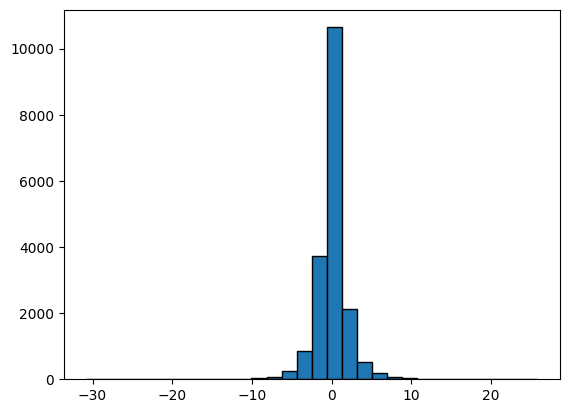

In [5]:
plt.hist(air_data['pm10_delta'], bins=30, edgecolor='k')
plt.show()

In [6]:
corr_matrix = air_data.corr()
print(corr_matrix["pm10_delta"].sort_values(ascending=False))

pm10_delta                      1.000000
is_busy                         0.211123
temperature_pressure            0.035466
temperature_2m                  0.035277
surface_pressure                0.034399
wind_speed_delta                0.031765
temperature_rolling_3h_mean     0.019798
temperature_rolling_6h_mean     0.015473
temp_humidity_rolling_3h        0.015464
temp_humidity_2m                0.011597
wind_speed_10m                  0.002556
temperature_rolling_12h_mean   -0.001301
temperature_rolling_24h_mean   -0.002838
wind_speed_lag_1h              -0.020271
hour_sin                       -0.021802
precipitation                  -0.029807
stagnation                     -0.030284
pm10_lag_1d                    -0.038103
wind_speed_lag_2h              -0.038143
relative_humidity_2m           -0.054536
wind_speed_lag_3h              -0.060404
pm10_lag_1h                    -0.097639
wind_volatility_interaction    -0.114944
pm10_rolling_6h_std            -0.140950
pm10_rolling_12h

In [7]:
# Splitting into training and testing
y = air_data['pm10_delta']
X = air_data.drop(columns=['pm10_delta'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=False)

In [8]:
model = XGBRegressor(
    random_state=42,
    gamma=0.25,
    learning_rate=0.004,
    n_estimators=750,
    max_depth=4
)

In [9]:
# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
# Evaluate
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.3f}")
print(f"R^2: {r2_score(y_test, y_pred):.3f}")

MAE: 1.128
RMSE: 1.673
R^2: 0.331


In [12]:
# Feature importances for the model
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                         Feature  Importance
26          temperature_pressure    0.082357
5                        is_busy    0.067489
11                      hour_cos    0.063713
8                    pm10_lag_3h    0.060491
0                 temperature_2m    0.051384
20  temperature_rolling_24h_mean    0.050425
21          pm10_rolling_6h_mean    0.048420
25              temp_humidity_2m    0.047865
17   temperature_rolling_3h_mean    0.045927
6                    pm10_lag_1h    0.037804
10                      hour_sin    0.037127
19  temperature_rolling_12h_mean    0.033724
3                  precipitation    0.031328
27      temp_humidity_rolling_3h    0.030150
14             wind_speed_lag_2h    0.029031
9                    pm10_lag_1d    0.028867
7                    pm10_lag_2h    0.028840
2           relative_humidity_2m    0.027077
15             wind_speed_lag_3h    0.025470
22           pm10_rolling_6h_std    0.024398
16              wind_speed_delta    0.021211
4         